# Trabajo Práctico 0 - Umbralización y reconocimiento de regiones
## I308 - Visión Artificial
### Martina Grünewald (34582)
---

Este es un trabajo interactivo individual que deberán completar y entregar.

Se espera que ganen experiencia y experimenten con varios métodos de binarización, segmentación y reconocimiento de regiones.

Pueden utilizar las herramientas provistas por la librería OpenCV para resolver los ejercicios.

Método de entrega:
- Entregar a través del campus virtual una estructura de directorios con todos los recursos y scripts para resolver los ejercicios.
- Dentro de los archivos de entrega debe encontrarse este jupyter notebook resuelto (debe entregarse "ejecutado" mostrando los resultados).

**NO SE REQUIERE ENTREGAR INFORME PARA ESTE TP**

In [1]:
# Se define el entorno detectando y paths de recursos detectando si se está ejecutando en google colab.

import os
import sys

try:
  from google.colab import drive
  RUNNING_IN_COLAB = True
except:
  RUNNING_IN_COLAB = False

# Configuración del directorio de recursos
IMGS_PATH = "imgs/"

if(RUNNING_IN_COLAB):
    drive.mount('/content/drive')

    BASE_DIR = "/content/drive/MyDrive/UdeSA/I308Vision/TPs"
    TUTORIAL = "tp0_binarizacion_regiones"

    TUTORIAL_PATH = os.path.join(BASE_DIR, TUTORIAL)
    IMGS_PATH = os.path.join(TUTORIAL_PATH, IMGS_PATH)

    # Cambiando el path del entorno de colab (los recursos pueden referenciarse directamente o con RESOURCES_PATH)
    %cd {TUTORIAL_PATH}
    sys.path.append(TUTORIAL_PATH)

In [2]:
# Librerías recomendadas para la ejercitación

import utils
import cv2
import numpy as np
from matplotlib import pyplot as plt

---
# Umbralización o binarización de una imagen

Un proceso de umbralización o binarizacion consiste en transformar una imagen a blanco y negro, donde existan solo dos resultados posibles, 0 o 1 (o 0 y 255).

El objetivo del proceso de binarización es resaltar regiones de interés, una manera de hacerlo es crear una "máscara" de la imagen. Una máscara es una imagen binaria del mismo ancho y alto que la original, donde el valor de los píxeles de interés será 255 (o 1) y 0 para cualquier otro píxel.

### Ejercicio 1:
Generar 5 máscaras binarias resaltando cada uno de los diferentes colores de confites en las imágenes 'imgs/inputs/confitesX.jpg'.

Imagen de entrada 'imgs/inputs/confites1.jpg':



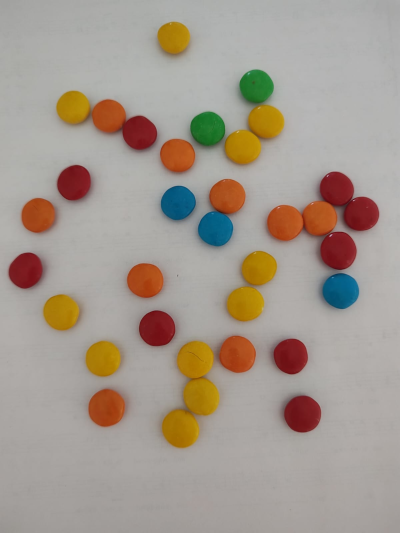

Graficar el resultado de las 5 máscaras.
Ejemplo: La máscara binaria para los confites naranjas tendrá 255 solo en los píxeles que refieran a los chocolates color naranja.

Ejemplo de salida esperada:

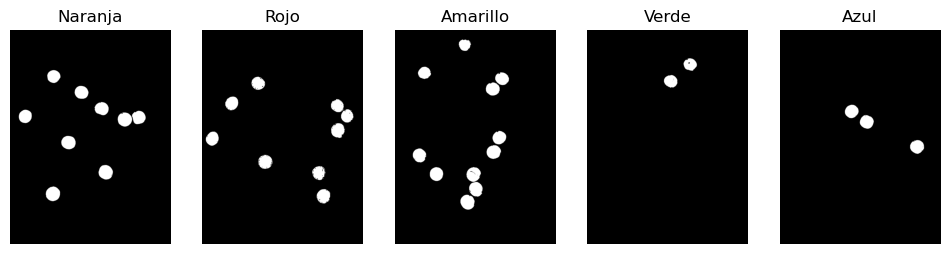

Investigar las funciones de opencv: cv2.cvtColor, cv2.inRange, cv2.threshold.

---
### RESOLUCIÓN DEL EJERCICIO 1

In [3]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Primero veremos el procedimiento con la primera imagen.

(-0.5, 1199.5, 1599.5, -0.5)

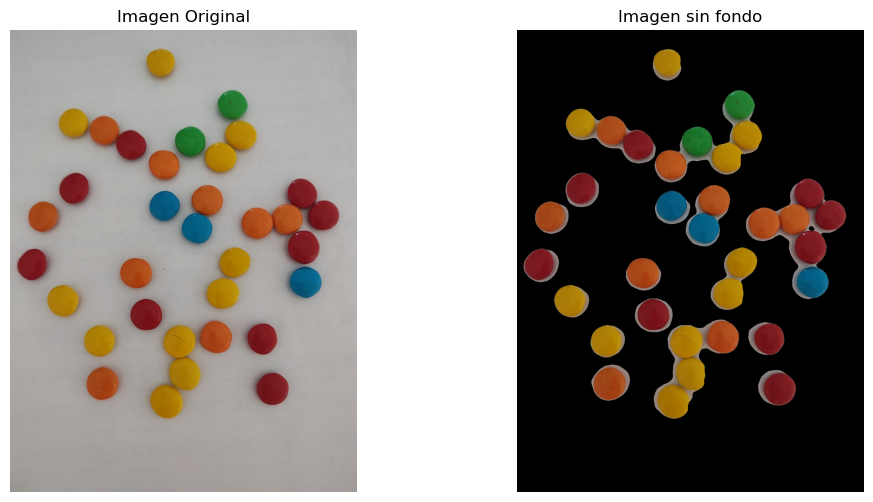

In [4]:
img_original = cv2.imread('imgs/inputs/confites1.jpg')
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_original_byn = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

#separamos el fondo blanco de los confites
img_blur = cv2.medianBlur(img_original_byn, 15)
umbral = 144  
mascara_fondo = np.uint8(img_blur >= umbral) * 255  
mascara_rocklets = cv2.bitwise_not(mascara_fondo) 
img_sin_fondo = cv2.bitwise_and(img_original, img_original, mask=mascara_rocklets)
img_sin_fondo_rgb = cv2.cvtColor(img_sin_fondo, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img_original_rgb)
axs[0].set_title("Imagen Original")
axs[0].axis("off")
axs[1].imshow(img_sin_fondo_rgb)
axs[1].set_title("Imagen sin fondo")
axs[1].axis("off")

(-0.5, 1199.5, 1599.5, -0.5)

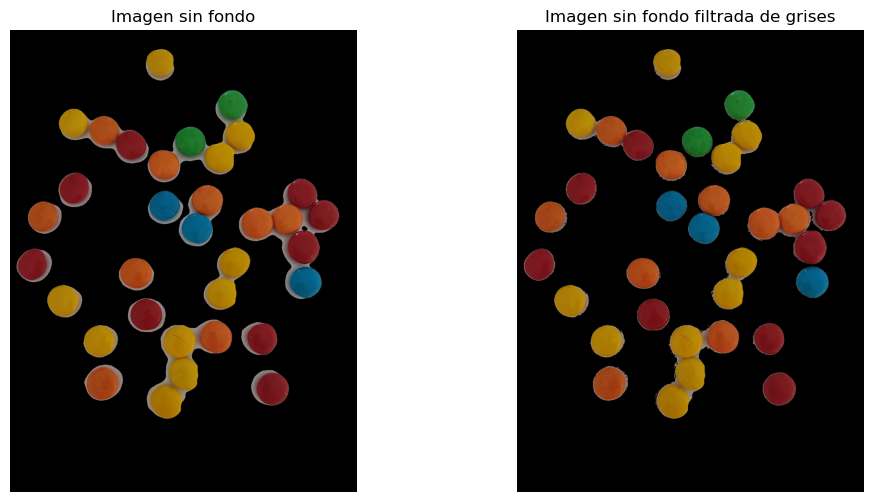

In [5]:


#elimino todo lo que tenga saturación baja = grises en HSV
img_sin_fondo_hsv = cv2.cvtColor(img_sin_fondo, cv2.COLOR_BGR2HSV)
img_a_filtrar = img_sin_fondo_hsv
sat_threshold = 50 
low_saturation_mask = img_a_filtrar[:, :, 1] < sat_threshold
img_a_filtrar[low_saturation_mask] = [0, 0, 0]
img_filtada_rgb = cv2.cvtColor(img_a_filtrar, cv2.COLOR_HSV2RGB)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img_sin_fondo_rgb)
axs[0].set_title("Imagen sin fondo")
axs[0].axis("off")
axs[1].imshow(img_filtada_rgb)
axs[1].set_title("Imagen sin fondo filtrada de grises")
axs[1].axis("off")


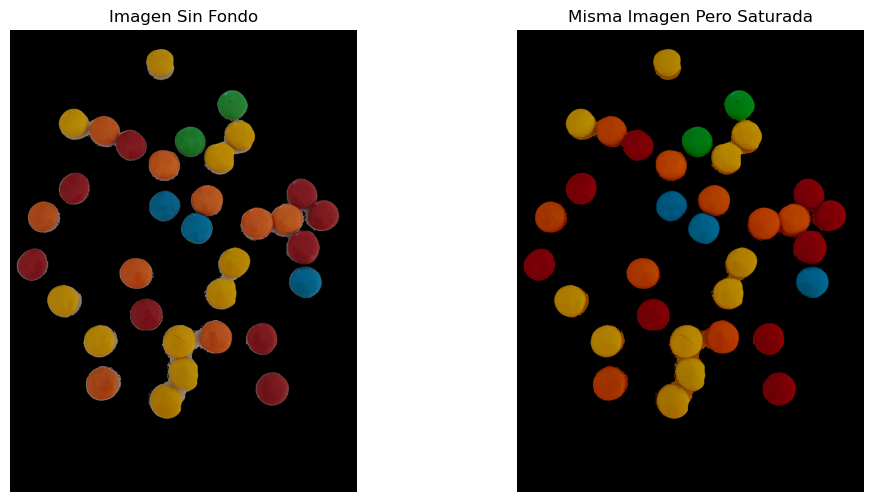

In [6]:
#saturamos la imágen para deshacernos de subtonos/sombras de los confites
img_a_saturar = cv2.cvtColor(img_filtada_rgb, cv2.COLOR_RGB2HSV)
factor_saturacion = 20.0 
img_a_saturar[:, :, 1] = np.clip(img_a_saturar[:, :, 1] * factor_saturacion, 0, 255)

img_saturada = cv2.cvtColor(img_a_saturar, cv2.COLOR_HSV2BGR)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img_filtada_rgb)
axs[0].set_title("Imagen Sin Fondo")
axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(img_saturada, cv2.COLOR_BGR2RGB))
axs[1].set_title("Misma Imagen Pero Saturada")
axs[1].axis("off")
plt.show()


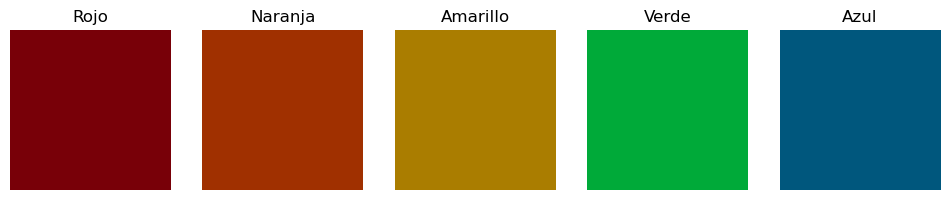

In [7]:
#buscamos un color similar al del confite promedio
colores_confites = { #hsv - colores de confites
    "Rojo": (178, 255, 120),
    "Naranja": (9, 255, 160),
    "Amarillo": (22, 255, 170),
    "Verde": (70, 255, 170),
    "Azul":  (99, 255, 125),
}

fig, axs = plt.subplots(1, len(colores_confites), figsize=(12, 3))
for i, (color_name, hsv) in enumerate(colores_confites.items()):
    color_bgr = cv2.cvtColor(np.uint8([[hsv]]), cv2.COLOR_HSV2BGR)[0][0]  
    color_rgb = cv2.cvtColor(np.array([[color_bgr]], dtype=np.uint8), cv2.COLOR_BGR2RGB)[0][0] 
    rect = np.full((100, 100, 3), color_rgb, dtype=np.uint8) 
    axs[i].imshow(rect)
    axs[i].set_title(color_name)
    axs[i].axis("off")
plt.show()


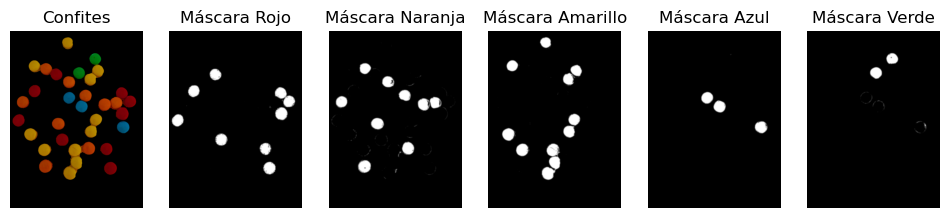

In [8]:
##ahora vamos a teñir de uno de estos 5 colores a cada pixel no nulo, para eso vemos la cercanía en el plano HSV con estos 5 colores
img_hsv = cv2.cvtColor(img_saturada, cv2.COLOR_BGR2HSV)

# rojo
rojo_hsv = (178, 255, 120)
lower_bound_rojo = np.array([max(0, rojo_hsv[0] - 30), max(0, rojo_hsv[1] - 30), max(0, rojo_hsv[2] - 30)], dtype=np.uint8)
upper_bound_rojo = np.array([min(179, rojo_hsv[0] + 30), min(255, rojo_hsv[1] + 30), min(255, rojo_hsv[2] + 30)], dtype=np.uint8)
mascara_rojo = cv2.inRange(img_hsv, lower_bound_rojo, upper_bound_rojo)

# naranja 
naranja_hsv = (5, 255, 170)
lower_bound_naranja = np.array([max(0, naranja_hsv[0] - 10), max(0, naranja_hsv[1] - 25), max(0, naranja_hsv[2] - 17)], dtype=np.uint8)
upper_bound_naranja = np.array([min(179, naranja_hsv[0] + 10), min(255, naranja_hsv[1] + 25), min(255, naranja_hsv[2] + 17)], dtype=np.uint8)
mascara_naranja = cv2.inRange(img_hsv, lower_bound_naranja, upper_bound_naranja)

# amarillo -- tengo que usar difrentes rangos para H, S y V porque si muevo todo con los mismos rangos lo confunde con naranja
amarillo_hsv = (22, 255, 170)
lower_bound_amarillo = np.array([max(0, amarillo_hsv[0] - 9), max(0, amarillo_hsv[1] - 10), max(0, amarillo_hsv[2] - 17)], dtype=np.uint8)
upper_bound_amarillo = np.array([min(179, amarillo_hsv[0] + 9), min(255, amarillo_hsv[1] + 10), min(255, amarillo_hsv[2] + 17)], dtype=np.uint8)
mascara_amarillo = cv2.inRange(img_hsv, lower_bound_amarillo, upper_bound_amarillo)

# azul
azul_hsv = (99, 255, 125)
lower_bound_azul = np.array([max(0, azul_hsv[0] - 25), max(0, azul_hsv[1] - 25), max(0, azul_hsv[2] - 25)], dtype=np.uint8)
upper_bound_azul = np.array([min(179, azul_hsv[0] + 25), min(255, azul_hsv[1] + 25), min(255, azul_hsv[2] + 25)], dtype=np.uint8)
mascara_azul = cv2.inRange(img_hsv, lower_bound_azul, upper_bound_azul)

#verde (como con un rango de 40 la máscara azul detecta azules y verdes hago como una resta con la que detecta solo azules (misma pero con rango 25) para aislar solo los verdes)
lower_bound_verde_y_azul = np.array([max(0, azul_hsv[0] - 40), max(0, azul_hsv[1] - 40), max(0, azul_hsv[2] - 40)], dtype=np.uint8)
upper_bound_vered_y_azul = np.array([min(179, azul_hsv[0] + 40), min(255, azul_hsv[1] + 40), min(255, azul_hsv[2] + 40)], dtype=np.uint8)
mascara_verde_y_azul = cv2.inRange(img_hsv, lower_bound_verde_y_azul, upper_bound_vered_y_azul)
azul_inv = cv2.bitwise_not(mascara_azul)
mascara_verde  = cv2.bitwise_and(mascara_verde_y_azul, azul_inv)

fig, axs = plt.subplots(1, 6, figsize=(12, 4))
titulos = ["Máscara Rojo", "Máscara Naranja","Máscara Amarillo", "Máscara Azul", "Máscara Verde"]
mascaras = [mascara_rojo, mascara_naranja, mascara_amarillo, mascara_azul, mascara_verde]
axs[0].imshow(cv2.cvtColor(img_saturada, cv2.COLOR_BGR2RGB))
axs[0].set_title('Confites') 
axs[0].axis("off") 
for i in range(len(mascaras)):
    axs[i+1].imshow(cv2.blur(mascaras[i], (9, 9)), cmap='gray') #le aplico un filtro blur
    #axs[i+1].imshow(mascaras[i], cmap="gray")
    axs[i+1].set_title(titulos[i]) 
    axs[i+1].axis("off") 
plt.show()

#### Y si aplicamos este mismo procedimiento para las otras dos imágenes nos queda lo siguiente:

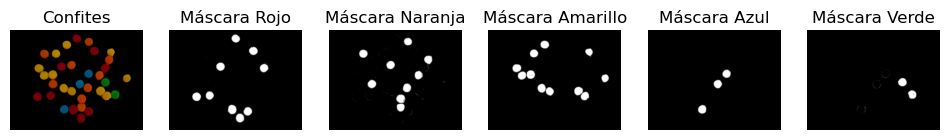

In [9]:
img_original_2 = cv2.imread('imgs/inputs/confites2.jpg')
img_original_2_byn = cv2.cvtColor(img_original_2, cv2.COLOR_BGR2GRAY)

img_blur_2 = cv2.medianBlur(img_original_2_byn, 15)
mascara_fondo_2 = np.uint8(img_blur_2 >= umbral) * 255  
mascara_rochlets_2 = cv2.bitwise_not(mascara_fondo_2) 
img_sin_fondo_2 = cv2.bitwise_and(img_original_2, img_original_2, mask=mascara_rochlets_2)
img_sin_fondo_2_rgb = cv2.cvtColor(img_sin_fondo_2, cv2.COLOR_BGR2RGB)

img_sin_fondo_2_hsv = cv2.cvtColor(img_sin_fondo_2, cv2.COLOR_BGR2HSV)
img_a_filtrar_2 = img_sin_fondo_2_hsv
low_saturation_mask_2 = img_a_filtrar_2[:, :, 1] < sat_threshold
img_a_filtrar_2[low_saturation_mask_2] = [0, 0, 0]
img_filtada_2_rgb = cv2.cvtColor(img_a_filtrar_2, cv2.COLOR_HSV2RGB)

img_a_saturar_2 = cv2.cvtColor(img_filtada_2_rgb, cv2.COLOR_RGB2HSV)
img_a_saturar_2[:, :, 1] = np.clip(img_a_saturar_2[:, :, 1] * factor_saturacion, 0, 255)
img_saturada_2 = cv2.cvtColor(img_a_saturar_2, cv2.COLOR_HSV2BGR)

img_hsv_2 = cv2.cvtColor(img_saturada_2, cv2.COLOR_BGR2HSV)

mascara_rojo_2 = cv2.inRange(img_hsv_2, lower_bound_rojo, upper_bound_rojo)
mascara_naranja_2 = cv2.inRange(img_hsv_2, lower_bound_naranja, upper_bound_naranja)
mascara_amarillo_2 = cv2.inRange(img_hsv_2, lower_bound_amarillo, upper_bound_amarillo)
mascara_azul_2 = cv2.inRange(img_hsv_2, lower_bound_azul, upper_bound_azul)
mascara_verde_y_azul_2 = cv2.inRange(img_hsv_2, lower_bound_verde_y_azul, upper_bound_vered_y_azul)
azul_inv_2 = cv2.bitwise_not(mascara_azul_2)
mascara_verde_2 = cv2.bitwise_and(mascara_verde_y_azul_2, azul_inv_2)

fig, axs = plt.subplots(1, 6, figsize=(12, 4))
titulos = ["Máscara Rojo", "Máscara Naranja","Máscara Amarillo", "Máscara Azul", "Máscara Verde"]
mascaras = [mascara_rojo_2, mascara_naranja_2, mascara_amarillo_2, mascara_azul_2, mascara_verde_2]
axs[0].imshow(cv2.cvtColor(img_saturada_2, cv2.COLOR_BGR2RGB))
axs[0].set_title('Confites') 
axs[0].axis("off") 
for i in range(len(mascaras)):
    axs[i+1].imshow(cv2.blur(mascaras[i], (9, 9)), cmap='gray')
    axs[i+1].set_title(titulos[i]) 
    axs[i+1].axis("off") 
plt.show()


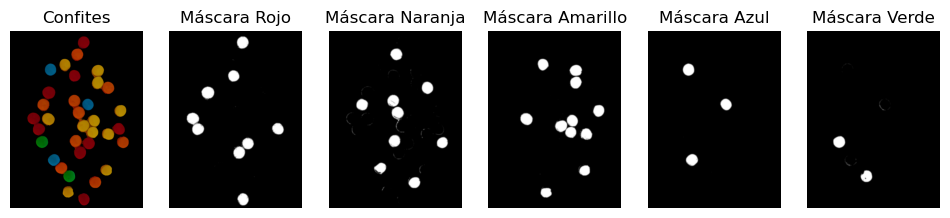

In [10]:
img_original_3 = cv2.imread('imgs/inputs/confites3.jpg')
img_original_3_byn = cv2.cvtColor(img_original_3, cv2.COLOR_BGR2GRAY)

img_blur_3 = cv2.medianBlur(img_original_3_byn, 15)
mascara_fondo_3 = np.uint8(img_blur_3 >= umbral) * 255  
mascara_rochlets_3 = cv2.bitwise_not(mascara_fondo_3) 
img_sin_fondo_3 = cv2.bitwise_and(img_original_3, img_original_3, mask=mascara_rochlets_3)
img_sin_fondo_3_rgb = cv2.cvtColor(img_sin_fondo_3, cv2.COLOR_BGR2RGB)

img_sin_fondo_3_hsv = cv2.cvtColor(img_sin_fondo_3, cv2.COLOR_BGR2HSV)
img_a_filtrar_3 = img_sin_fondo_3_hsv
low_saturation_mask_3 = img_a_filtrar_3[:, :, 1] < sat_threshold
img_a_filtrar_3[low_saturation_mask_3] = [0, 0, 0]
img_filtada_3_rgb = cv2.cvtColor(img_a_filtrar_3, cv2.COLOR_HSV2RGB)

img_a_saturar_3 = cv2.cvtColor(img_filtada_3_rgb, cv2.COLOR_RGB2HSV)
img_a_saturar_3[:, :, 1] = np.clip(img_a_saturar_3[:, :, 1] * factor_saturacion, 0, 255)
img_saturada_3 = cv2.cvtColor(img_a_saturar_3, cv2.COLOR_HSV2BGR)

img_hsv_3 = cv2.cvtColor(img_saturada_3, cv2.COLOR_BGR2HSV)

mascara_rojo_3 = cv2.inRange(img_hsv_3, lower_bound_rojo, upper_bound_rojo)
mascara_naranja_3 = cv2.inRange(img_hsv_3, lower_bound_naranja, upper_bound_naranja)
mascara_amarillo_3 = cv2.inRange(img_hsv_3, lower_bound_amarillo, upper_bound_amarillo)
mascara_azul_3 = cv2.inRange(img_hsv_3, lower_bound_azul, upper_bound_azul)
mascara_verde_y_azul_3 = cv2.inRange(img_hsv_3, lower_bound_verde_y_azul, upper_bound_vered_y_azul)
azul_inv_3 = cv2.bitwise_not(mascara_azul_3)
mascara_verde_3 = cv2.bitwise_and(mascara_verde_y_azul_3, azul_inv_3)

fig, axs = plt.subplots(1, 6, figsize=(12, 4))
titulos = ["Máscara Rojo", "Máscara Naranja","Máscara Amarillo", "Máscara Azul", "Máscara Verde"]
mascaras = [mascara_rojo_3, mascara_naranja_3, mascara_amarillo_3, mascara_azul_3, mascara_verde_3]
axs[0].imshow(cv2.cvtColor(img_saturada_3, cv2.COLOR_BGR2RGB))
axs[0].set_title('Confites') 
axs[0].axis("off") 
for i in range(len(mascaras)):
    axs[i+1].imshow(cv2.blur(mascaras[i], (9, 9)), cmap='gray')
    axs[i+1].set_title(titulos[i]) 
    axs[i+1].axis("off") 
plt.show()

---
# Análisis de Componentes Conexas

Las componentes conexas se definen como regiones de píxeles adyacentes que tienen un mismo valor de entrada o "etiqueta".
Al trabajar con imágenes binarias, una componente conexa es un conjunto de píxeles adyacentes entre sí que poseen valor 1 (o 255).

La vecidad entre píxeles puede definirse como:
- 4-Connectivity: se consideran vecinos los píxeles que están horizontal o verticalmente adyacentes al píxel central: (-1, 0) (+1, 0), (0, -1), (0, +1).

- 8-Connectivity: igual a 4-Connectivity pero además se consideran vecinos los píxeles que están en diagonal adyacentes al píxel central: (-1, -1) (-1, +1), (+1, -1), (+1, +1).

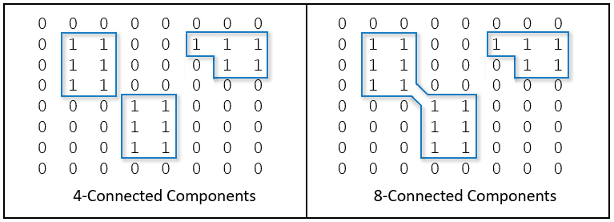

Para lograr una segmentación en componentes conexas, es posible interpretar una imagen como un grafo:

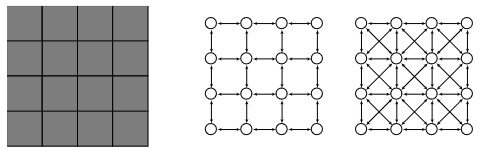

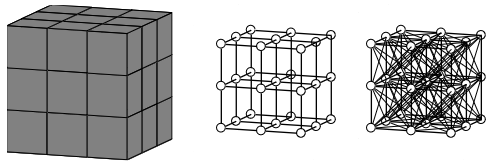

Este tipo de representaciones dieron lugar a un área de estudio conocida como Procesamiento de Imágenes basado en Grafos (*Graph-based image processing*).
Los algoritmos que permiten encontrar componentes conexas eficientemente provienen, entonces, del área de teoría de grafos.

Es posible encontrar componentes conexas de un grafo utilizando DFS (*Depth First Search*) apilando los índices de los vecinos visitados ([Connected Components in an Undirected Graph](https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/)).

Al trabajar con imágenes (grillas bidimensionales) es posible aplicar algoritmos aún más eficientes, como el *Two-Pass Algorithm* ([Implementing a Connected Component Labeling algorithm from scratch](https://medium.com/towards-data-science/implementing-a-connected-component-labeling-algorithm-from-scratch-94e1636554f).

OpenCV provee las funciones [`cv2.connectedComponents` y `cv2.connectedComponentsWithStats`](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gaedef8c7340499ca391d459122e51bef5), que se utilizan para encontrar componentes conexas en imágenes.





### Ejemplo de utilización de cv2.connectedComponentsWithStats()

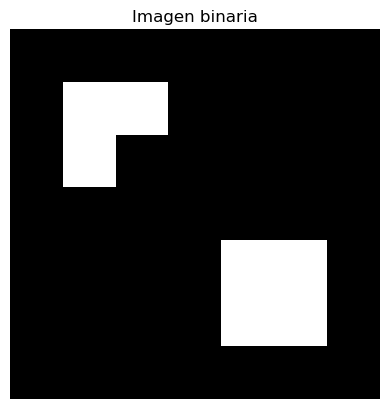

CC0 tiene 42 píxeles.
CC1 tiene 3 píxeles.
CC2 tiene 4 píxeles.


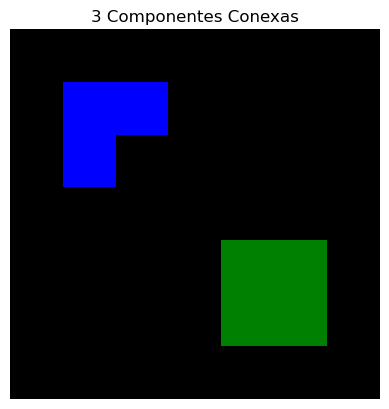

In [11]:

from matplotlib.colors import ListedColormap

# Inicializamos una imagen binaria
binary_img = np.zeros((7, 7)).astype('uint8')
binary_img[1, 1] = 255
binary_img[1, 2] = 255
binary_img[2, 1] = 255

binary_img[4, 4] = 255
binary_img[5, 5] = 255
binary_img[5, 4] = 255
binary_img[4, 5] = 255

plt.figure()
utils.imshow(binary_img)
plt.title("Imagen binaria")
plt.show()


(num_labels, img_labels, values, centroids) = cv2.connectedComponentsWithStats(binary_img)

for i in range(num_labels):
    area = values[i, cv2.CC_STAT_AREA]
    print("CC" + str(i) + " tiene " + str(area) + " píxeles.")

# El fondo también es una componente conexa
cmap = ListedColormap(['black', 'blue', 'green'])

plt.figure()
utils.imshow(img_labels, cmap=cmap)
plt.title(str(num_labels) + " Componentes Conexas")
plt.show()

### Ejercicio 2:
Contar la cantidad de confites de cada color en las imágenes de confites provistas en 'imgs/imputs/'.

Deben utilizar las máscaras binarias obtenidos del ejercicio anterior y etiquetar las imágenes utilizando el algoritmos de componentes conexas.

Pueden suponer que todas las imágenes son (y serán) tomadas a la misma distancia, es decir, los confites son siempre "aproximadamente" del mismo tamaño.
Y que la iluminación no cambia drásticamente entre imágenes, es decir, los confites se verán aproximadamente del mismo color siempre.

Ejemplo de salida esperada:

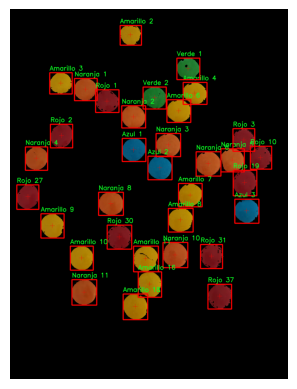

Investigar las funciones de opencv: connectedComponents, connectedComponentsWithStats.

---
### RESOLUCIÓN DEL EJERCICIO 2
#### Primero veremos el procedimiento

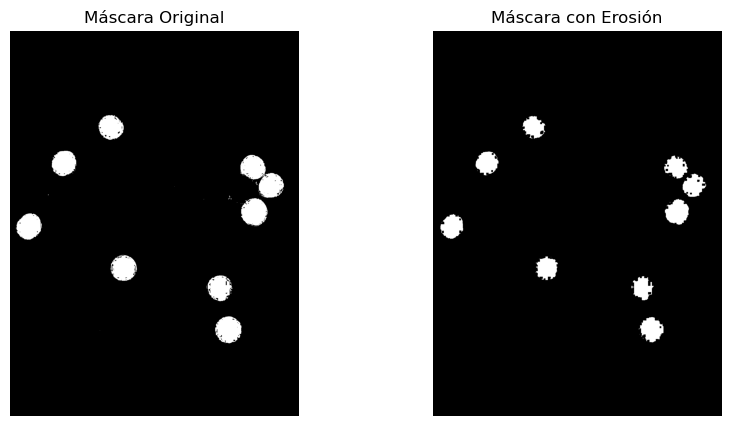

In [12]:
mascaras = [mascara_rojo, mascara_naranja, mascara_amarillo, mascara_azul, mascara_verde]

#como hay confites muy pegados (por la super saturación que metimos antes) que figuran como una única componente conexa agregamos un operador de erosion para separarlos
kernel = np.ones((7, 7), np.uint8)  
mascaras_erosionadas = []

for masc in mascaras:
    mascaras_erosionadas.append(cv2.erode(masc, kernel, iterations=1))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mascara_rojo, cmap='gray')
plt.axis('off')
plt.title("Máscara Original")
plt.subplot(1, 2, 2)
plt.imshow(mascaras_erosionadas[0], cmap='gray')
plt.axis('off')
plt.title("Máscara con Erosión")
plt.show()

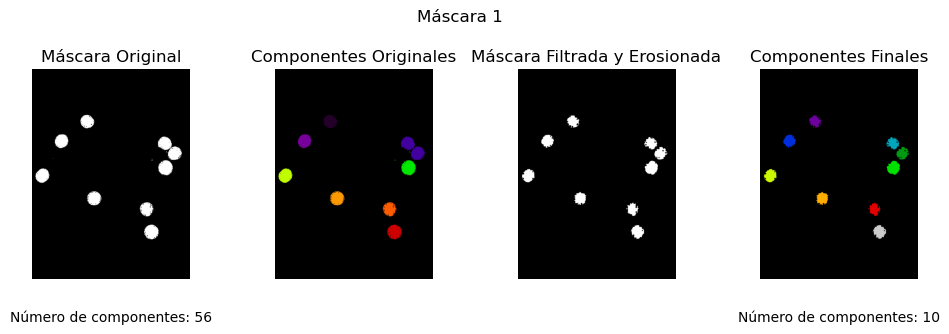

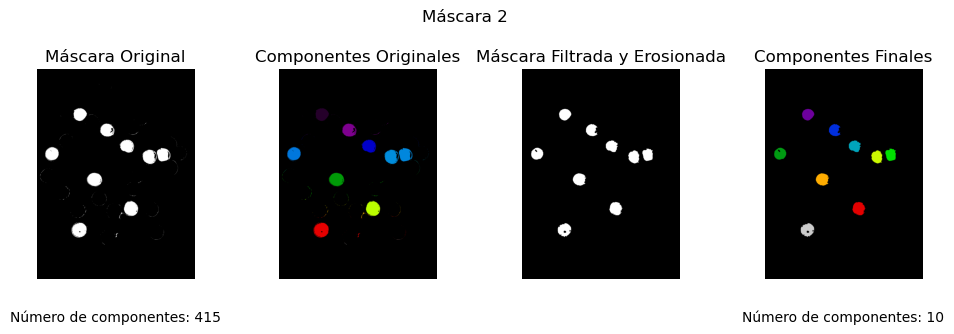

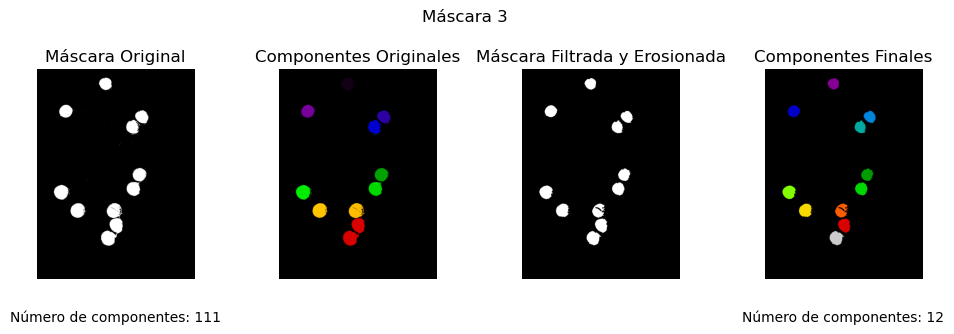

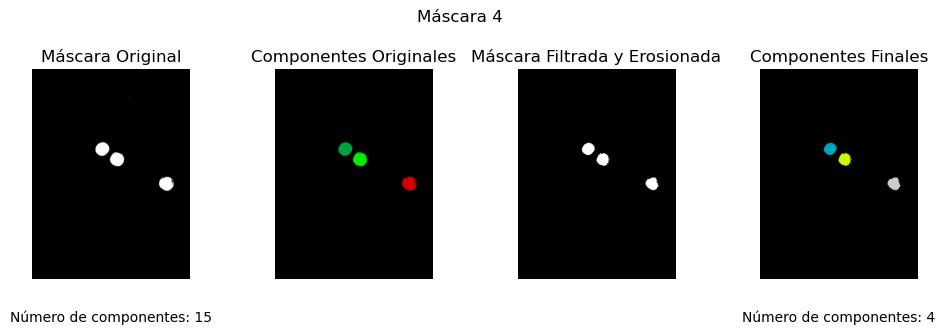

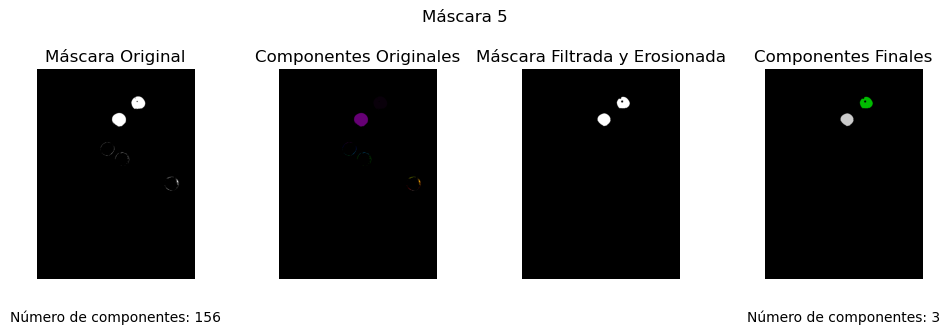

La cantidad de confites es componentes-1 ya que tiene en cuenta el fondo


In [13]:
#mapeamos a negro cualquier componente conectada con menos de 3000 píxeles
for i, mascara in enumerate(mascaras_erosionadas):
    n_cc, img_cc, values, centroids = cv2.connectedComponentsWithStats(mascara, connectivity=8)
    mascara_filtrada = mascara.copy()
    for j in range(1, n_cc):  # ignora el fondo (j=0)
        area = values[j, cv2.CC_STAT_AREA]  # n de pixeles del componente
        if area < 3000:
            mascara_filtrada[img_cc == j] = 0
    n_cc_f, img_cc_f, values_f, centroids_f = cv2.connectedComponentsWithStats(mascara_filtrada, connectivity=8)
    n_cc_antes, img_cc_antes, values_antes, centroids_antes = cv2.connectedComponentsWithStats(mascaras[i], connectivity=8)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 4, 1)
    plt.imshow(mascaras[i], cmap='gray')
    plt.axis('off')
    plt.title("Máscara Original")
    plt.text(0.5, -0.2, f"Número de componentes: {n_cc_antes}", fontsize=10, ha='center', transform=plt.gca().transAxes)

    plt.subplot(2, 4, 2)
    plt.imshow(img_cc_antes, cmap='nipy_spectral')
    plt.axis('off')
    plt.title("Componentes Originales")

    plt.subplot(2, 4, 3)
    plt.imshow(mascara_filtrada, cmap='gray')
    plt.axis('off')
    plt.title("Máscara Filtrada y Erosionada")

    plt.subplot(2, 4, 4)
    plt.imshow(img_cc_f, cmap='nipy_spectral')
    plt.axis('off')
    plt.title("Componentes Finales")
    plt.text(0.5, -0.2, f"Número de componentes: {n_cc_f}", fontsize=10, ha='center', transform=plt.gca().transAxes)

    plt.suptitle(f"Máscara {i+1}")
    plt.show()

    mascaras_erosionadas[i] = mascara_filtrada

print("La cantidad de confites es componentes-1 ya que tiene en cuenta el fondo")

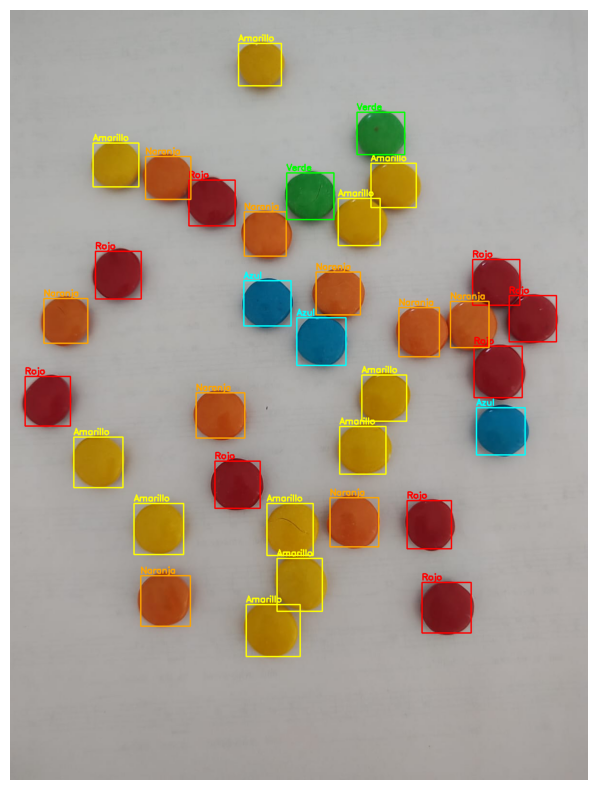

In [14]:
imagen_con_recuadros = img_original
textos = ["Rojo", "Naranja", "Amarillo", "Azul", "Verde"]
colores_mascaras = [(0, 0, 255), (0, 165, 255), (0, 255, 255), (255, 255, 0), (0, 255, 0), (255, 0, 0)]

for i, mascara in enumerate(mascaras_erosionadas):
    color = colores_mascaras[i % len(colores_mascaras)]  
    texto = textos[i % len(textos)]
    n_cc, im_cc, values, centroids = cv2.connectedComponentsWithStats(mascara, connectivity=8)

    for j in range(1, n_cc): # no incluye al fondo
        x, y, w, h, area = values[j]
        cv2.rectangle(imagen_con_recuadros, (x, y), (x + w, y + h), color, 2)
        cv2.putText(imagen_con_recuadros, texto, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imagen_con_recuadros, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


#### Con la imagen 2

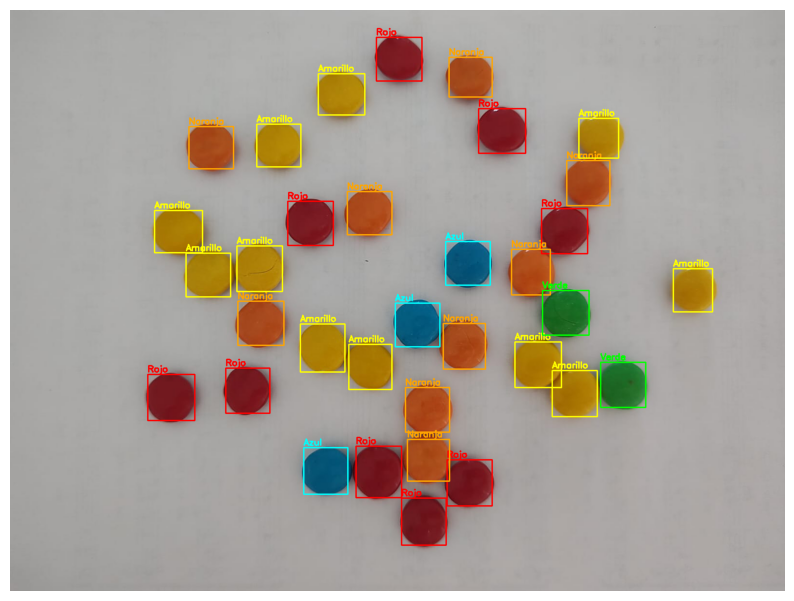

In [15]:
# para la 2da imagen
mascaras_2 = [mascara_rojo_2, mascara_naranja_2, mascara_amarillo_2, mascara_azul_2, mascara_verde_2]
mascaras_erosionadas_2 = []
for masc in mascaras_2:
    mascaras_erosionadas_2.append(cv2.erode(masc, kernel, iterations=1))

for i, mascara in enumerate(mascaras_erosionadas_2):
    n_cc, img_cc, values, centroids = cv2.connectedComponentsWithStats(mascara, connectivity=8)
    mascara_filtrada_2 = mascara.copy()
    for j in range(1, n_cc): 
        area = values[j, cv2.CC_STAT_AREA]  
        if area < 3000:
            mascara_filtrada_2[img_cc == j] = 0
    mascaras_erosionadas_2[i] = mascara_filtrada_2

imagen_con_recuadros_2 = img_original_2
textos = ["Rojo", "Naranja", "Amarillo", "Azul", "Verde"]
colores_mascaras = [(0, 0, 255), (0, 165, 255), (0, 255, 255), (255, 255, 0), (0, 255, 0), (255, 0, 0)]

for i, mascara in enumerate(mascaras_erosionadas_2):
    color = colores_mascaras[i % len(colores_mascaras)]  
    texto = textos[i % len(textos)]
    n_cc, im_cc, values, centroids = cv2.connectedComponentsWithStats(mascara, connectivity=8)
    for j in range(1, n_cc): 
        x, y, w, h, area = values[j]
        cv2.rectangle(imagen_con_recuadros_2, (x, y), (x + w, y + h), color, 2)
        cv2.putText(imagen_con_recuadros_2, texto, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imagen_con_recuadros_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### Para la imagen 3

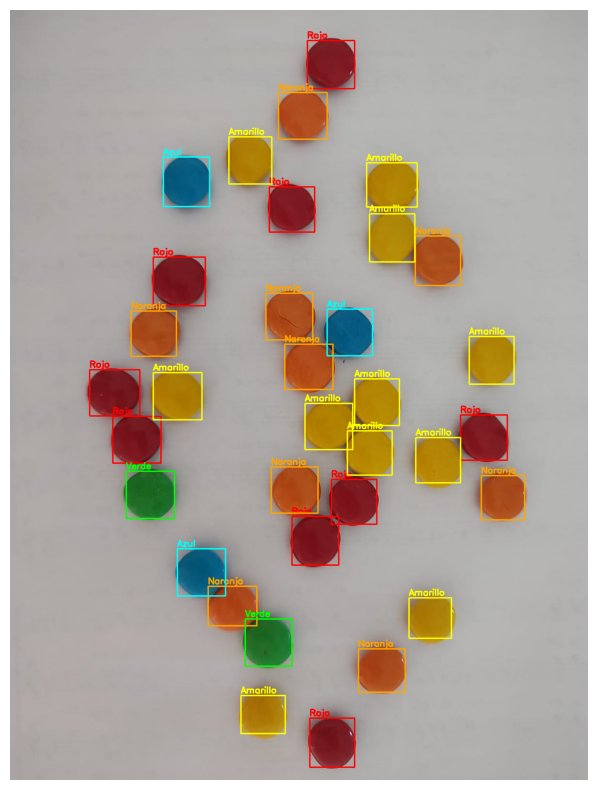

In [16]:
#para la 3er imagen
mascaras_3 = [mascara_rojo_3, mascara_naranja_3, mascara_amarillo_3, mascara_azul_3, mascara_verde_3]
mascaras_erosionadas_3 = []
for masc in mascaras_3:
    mascaras_erosionadas_3.append(cv2.erode(masc, kernel, iterations=1))

for i, mascara in enumerate(mascaras_erosionadas_3):
    n_cc, img_cc, values, centroids = cv2.connectedComponentsWithStats(mascara, connectivity=8)
    mascara_filtrada_3 = mascara.copy()
    for j in range(1, n_cc): 
        area = values[j, cv2.CC_STAT_AREA] 
        if area < 3000:
            mascara_filtrada_3[img_cc == j] = 0
    mascaras_erosionadas_3[i] = mascara_filtrada_3

imagen_con_recuadros_3 = img_original_3
textos = ["Rojo", "Naranja", "Amarillo", "Azul", "Verde"]
colores_mascaras = [(0, 0, 255), (0, 165, 255), (0, 255, 255), (255, 255, 0), (0, 255, 0), (255, 0, 0)]

for i, mascara in enumerate(mascaras_erosionadas_3):
    color = colores_mascaras[i % len(colores_mascaras)]  
    texto = textos[i % len(textos)]
    n_cc, im_cc, values, centroids = cv2.connectedComponentsWithStats(mascara, connectivity=8)
    for j in range(1, n_cc): 
        x, y, w, h, area = values[j]
        cv2.rectangle(imagen_con_recuadros_3, (x, y), (x + w, y + h), color, 2)
        cv2.putText(imagen_con_recuadros_3, texto, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imagen_con_recuadros_3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

---

# Algoritmos de umbralización

## Algoritmo de Otsu

Se conoce como imagen bimodal a aquella que consta de dos picos de intensidad principales. Estos picos o modos representan diferentes objetos, texturas o regiones dentro de la imagen que son significativamente diferentes entre sí en términos de niveles de intensidad.

El método de Otsu, llamado así por su creador Nobuyuki Otsu, permite encontrar un valor de umbralización global óptimo para imágenes bimodales. Este se basa en maximizar la varianza entre clases, una medida conocida utilizada en el análisis estadístico, (Capítulo 10.3; "Digital Image Processing", Gonzalez et al.).

Una animación que describe su accionar:

![OtsuVariance](https://upload.wikimedia.org/wikipedia/commons/3/34/Otsu%27s_Method_Visualization.gif "intra-class variance")

Visto de otro modo, el algoritmo de Otsu busca iterativamente el valor umbral $t$ que minimice la varianza "dentro de las clases", la cual se define como la suma ponderada de las varianzas de las dos clases. Estas dos clases se refieren en general como fondo (*background*) y primer plano (*foreground*).

De forma matemática, se busca el $t$ que minimice la varianza $\sigma_w^2(t)$:

$\underset{t}{\mathrm{argmin}} \: \sigma_w^2(t) = \underset{t}{\mathrm{argmin}} \: q_{bg}(t)\sigma_{bg}^2(t)+q_{fg}(t)\sigma_{fg}^2(t)$

donde:

$q_{bg}(t) = \sum_{i=1}^{t} p(i) \quad , \quad q_{fg}(t) = \sum_{i=t+1}^{I} p(i)$

$\mu_{bg}(t) = \sum_{i=1}^{t} \frac{ip(i)}{q_{bg}(t)} \quad , \quad \mu_{fg}(t) = \sum_{i=t+1}^{I} \frac{ip(i)}{q_{fg}(t)}$

$\sigma_{bg}^2(t) = \sum_{i=1}^{t} [i-\mu_{bg}(t)]^2 \frac{p(i)}{q_{bg}(t)} \quad , \quad \sigma_{fg}^2(t) = \sum_{i=t+1}^{I} [i-\mu_{fg}(t)]^2 \frac{p(i)}{q_{fg}(t)}$

donde $p(i)$ refieren al valor de frecuencia para la intensidad $i$.

## Algoritmos de umbralización adaptativa

En el caso del algoritmo de Otsu se utiliza un valor de umbral global, pero esto puede no ser suficiente en algunos casos, por ejemplo cuando una imagen presenta condiciones de iluminación muy variante.

Un algoritmo de binarización adaptativa determina un valor de umbral local para cada píxel en base al análisis de una pequeña región a su alrededor.

Un ejemplo de política adaptativa de umbralización para un determinado píxel es considerar como umbral la media de intensidad del área vecina al mismo. Si el píxel central es mayor que la media de sus vecinos entonces se lo binariza a 255 (o 1) y 0 en otro caso.

### Ejemplos de umbralización de Otsu y adaptativas

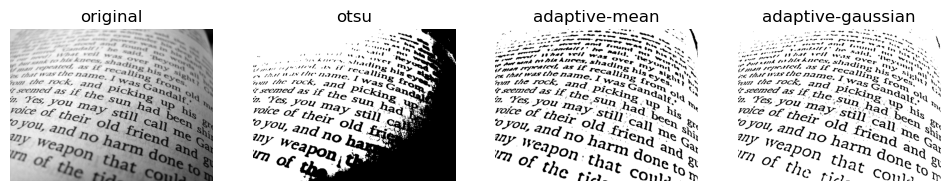

In [17]:
book_img = cv2.imread(IMGS_PATH + "resources/book.jpg", cv2.IMREAD_GRAYSCALE)

# Umbralización utilizando el algoritmo de Otsu
th, otsu_thresh = cv2.threshold(book_img, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Umbralización adaptativa utilizando utilizando la media del kernel
mean_thresh = cv2.adaptiveThreshold(
    book_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY, blockSize=19, C=16
)

# Umbralización adaptativa utilizando un kernel gaussiano
gaussian_thresh = cv2.adaptiveThreshold(
    book_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C ,
    cv2.THRESH_BINARY, blockSize=19, C=16
)

utils.show_images([book_img, otsu_thresh, mean_thresh, gaussian_thresh], ["original", "otsu", "adaptive-mean", "adaptive-gaussian"])

## Análisis morfológico de imágenes

La Morfología Matemática es una técnica de procesamiento y análisis de imágenes que tiene como objetivo procesar objetos en las imágenes de manera de extraer características de su "forma" (Capítulo 9, "Digital Image Processing", Gonzalez et al.). Tuvo gran repercusión y dió soluciones a muchos problemas en áreas como las del reconocimiento de texto y segmentación de imágenes médicas.

La morfología matemática se basa en teoría de conjuntos y define una serie de operaciones que permiten aplicar transformaciones a imágenes binarias. Estas transformaciones se basan en evaluar una región vecina alrededor de cada píxel, de manera similar al kernel de una convolución.

Al kernel utilizado en análisis morfológico se lo conoce como elemento estructurante (*structuring element*), y es binario:

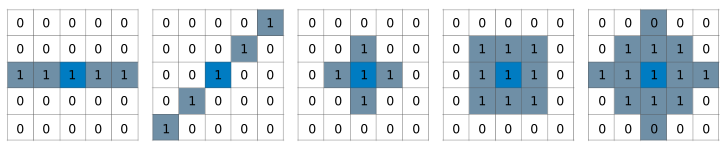

### Operador de Erosión:
Un píxel en la imagen binarizada (0 o 255) será considerado 255 solo si todos los píxeles bajo el elemento estructurante son 1, de otra manera el píxel es erosionado (puesto en 0). Esta transformación erosiona las componentes conexas presentes en la imágen binaria, reduciendo su "grosor".

Ejemplo de erosión utilizando un elemento estructurante cuadrado de 5x5:

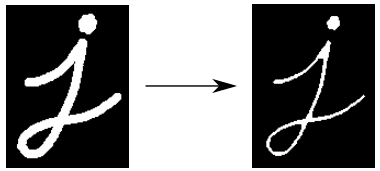

### Operador de Dilatación:
Esta operación es la opuesta a la erosión, un píxel en la imagen binarizada será evaluado en 255 si al menos un píxel del elemento estructurante es 1.

Un píxel en la imagen binarizada (0 o 255) será considerado 255 solo si todos los píxeles bajo el elemento estructurante son 1, de otra manera el píxel es erosionado (puesto en 0). Esta transformación produce una dilatación de las componentes conexas, ensanchándolas.

Ejemplo de dilatación utilizando un elemento estructurante cuadrado de 5x5:

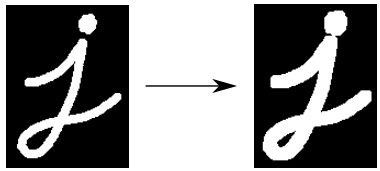

### La Transformada de Distancia:
La transformada de distancia reemplaza cada píxel de una imagen binaria con la distancia al píxel del *background* (valores en 0) más cercano. Si el píxel en sí ya forma parte del fondo, entonces esto es 0. El resultado es una imagen llamada mapa de distancias.

Ejemplo de un mapa de distancias aplicado a una región:

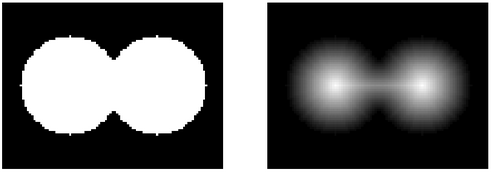

A partir de estos operadores y transformaciones básicas, el análisis morfológico define muchas otras operaciones más complejas, las cuales son ampliamente utilizadas en imágenes médicas, un recurso interesante es el ebook [Introduction to Bioimage Analysis](https://bioimagebook.github.io/index.html) de Pete Bankhead.

La librería de OpenCV tiene además su propia implementación de operaciones morfológicas: [Image Filters](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html) y [
Morphological Transformations
](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html).

## Ejercicio 3

Considerando todos los conceptos antes mencionados en este trabajo práctico, se pide contar la cantidad de células rojas en la imagen 'imgs/inputs/blood_cells.jpg' tomada por microscópio.

Las células rojas corresponden a los elementos de color 'rojo'/'rosado', pero deben notar que existen otros elementos de color 'azulado'/'púrpura'.
Estas otras células corresponden a células blancas presentes en la sangre. Notar que existen además otras pequeñas partículas en la imagen.

Deben entonces contar la cantidad de células rojas descartando cualquier otra células o partículas presentes en la imagen.

A continuación un ejemplo del resultado esperado por el método:

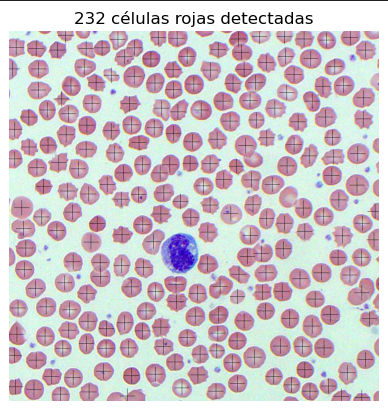

Notar que el resultado no es perfecto, existen en total 236 células rojas en la imagen (descartando aquellas en las esquinas con menos del 50% visible).

Un conteo entre 228 y 236 es aceptable.

Pueden suponer que las imágenes serán tomadas siempre a la misma distancia y que los elementos en la imagen son aproximadamente del mismo tamaño siempre. Pueden utilizar cualquier función de análisis de imágenes, detección de componentes conexas y contornos en openCV.

**Ayuda: pueden utilizar operaciones morfológicas para intentar dividir células rojas "pegadas" **

---
### RESOLUCIÓN DEL EJERCICIO 3

In [20]:
#iniciamos con el preprocesamiento de siempre

img_celulas  = cv2.imread('imgs/inputs/blood_cells.jpg')
img_celulas_byn = cv2.cvtColor(img_celulas, cv2.COLOR_BGR2GRAY)
img_blur = cv2.medianBlur(img_celulas_byn, 15)
umbral = 200  

#quitar el fondo
mascara_fondo = np.uint8(img_blur >= umbral) * 255  
mascara_celulas = cv2.bitwise_not(mascara_fondo) 
img_sin_fondo = cv2.bitwise_and(img_celulas, img_celulas, mask=mascara_celulas)
img_sin_fondo_rgb = cv2.cvtColor(img_sin_fondo, cv2.COLOR_BGR2RGB)

#saturar y deshacernos de las subtonalidades de las celulas (los centros más claros)
img_a_saturar = cv2.cvtColor(img_sin_fondo_rgb, cv2.COLOR_RGB2HSV)
factor_saturacion = 100.0 
img_a_saturar[:, :, 1] = np.clip(img_a_saturar[:, :, 1] * factor_saturacion, 0, 255)

#elimiar rasgos blancos/claros que no fueron detectados como fondos
img_saturada_hsv = cv2.cvtColor(img_saturada, cv2.COLOR_BGR2HSV)
umbral_v = 220  
mascara_v = img_saturada_hsv[:, :, 2] > umbral_v 
img_filtrada = img_saturada.copy()
img_filtrada[mascara_v] = [0, 0, 0]  

#mascara binaria
img_celulas_filtradas_byn = cv2.cvtColor(img_filtrada, cv2.COLOR_BGR2GRAY)
umbral = 50 
_, mascara_binaria = cv2.threshold(img_celulas_filtradas_byn, umbral, 255, cv2.THRESH_BINARY)

#erosionar mascara
kernel = np.ones((5, 5), np.uint8)  
img_binaria_erosionada = cv2.erode(mascara_binaria, kernel, iterations=1)
img_saturada = cv2.cvtColor(img_a_saturar, cv2.COLOR_HSV2BGR)


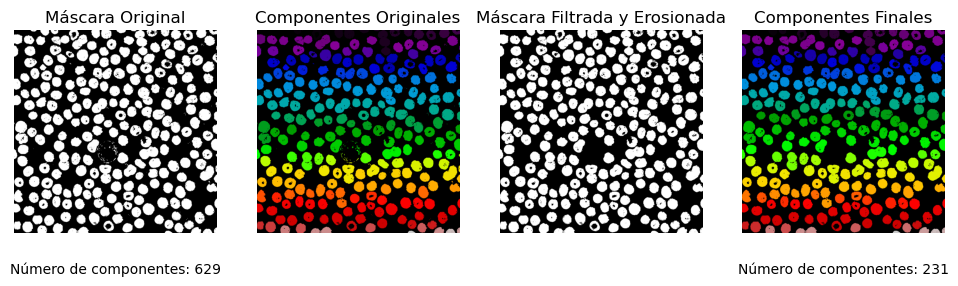

In [21]:
#elimino las componentes pequeñas
n_cc, img_cc, values, centroids = cv2.connectedComponentsWithStats(mascara_binaria, connectivity=8)
mascara_filtrada = mascara_binaria.copy()
for j in range(1, n_cc):  # ignora el fondo (j=0)
    area = values[j, cv2.CC_STAT_AREA]  # n de pixeles del componente
    if area < 250:
        mascara_filtrada[img_cc == j] = 0
n_cc_f, img_cc_f, values_f, centroids_f = cv2.connectedComponentsWithStats(mascara_filtrada, connectivity=8)
n_cc_antes, img_cc_antes, values_antes, centroids_antes = cv2.connectedComponentsWithStats(mascara_binaria, connectivity=8)

plt.figure(figsize=(12, 6))

plt.subplot(2, 4, 1)
plt.imshow(mascara_binaria, cmap='gray')
plt.axis('off')
plt.title("Máscara Original")
plt.text(0.5, -0.2, f"Número de componentes: {n_cc_antes}", fontsize=10, ha='center', transform=plt.gca().transAxes)

plt.subplot(2, 4, 2)
plt.imshow(img_cc_antes, cmap='nipy_spectral')
plt.axis('off')
plt.title("Componentes Originales")

plt.subplot(2, 4, 3)
plt.imshow(mascara_filtrada, cmap='gray')
plt.axis('off')
plt.title("Máscara Filtrada y Erosionada")

plt.subplot(2, 4, 4)
plt.imshow(img_cc_f, cmap='nipy_spectral')
plt.axis('off')
plt.title("Componentes Finales")
plt.text(0.5, -0.2, f"Número de componentes: {n_cc_f}", fontsize=10, ha='center', transform=plt.gca().transAxes)

plt.show()


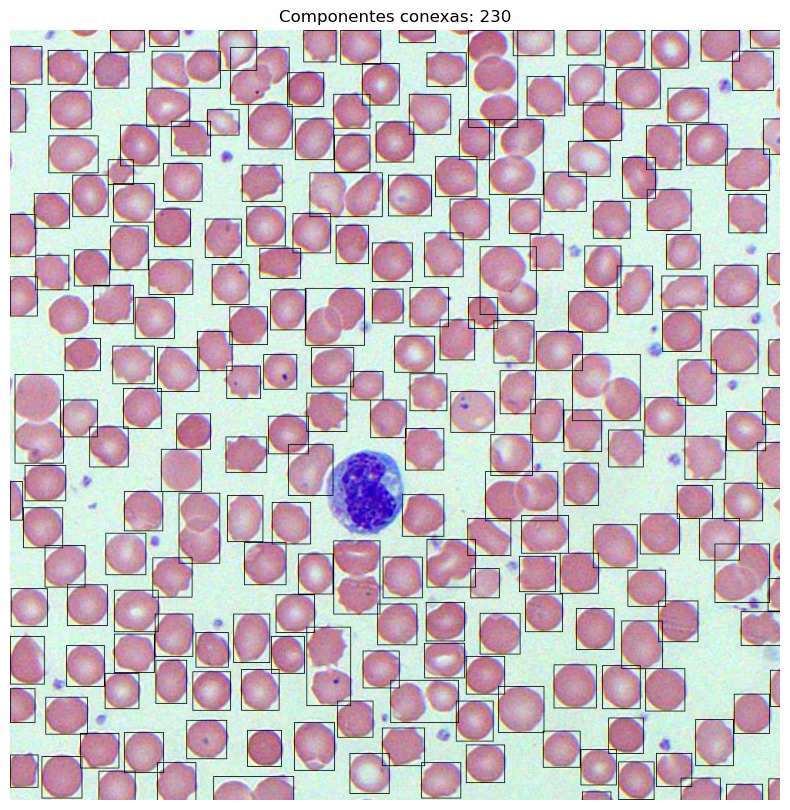

In [22]:
imagen_con_cuadraditos = img_celulas.copy()

n_cc, im_cc, values, centroids = cv2.connectedComponentsWithStats(mascara_filtrada, connectivity=8)
for j in range(1, n_cc): 
    if values[j, cv2.CC_STAT_AREA] < 500:
        mascara_filtrada[img_cc == j] = 0

n_cc_1, im_cc, values, centroids = cv2.connectedComponentsWithStats(mascara_filtrada, connectivity=8)

for j in range(1, n_cc_1): 
    x, y, w, h, area = values[j]
    cv2.rectangle(imagen_con_cuadraditos, (x, y), (x + w, y + h), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imagen_con_cuadraditos, cv2.COLOR_BGR2RGB))
plt.title(f"Componentes conexas: {n_cc_1}")
plt.axis('off')
plt.show()

CC= 25


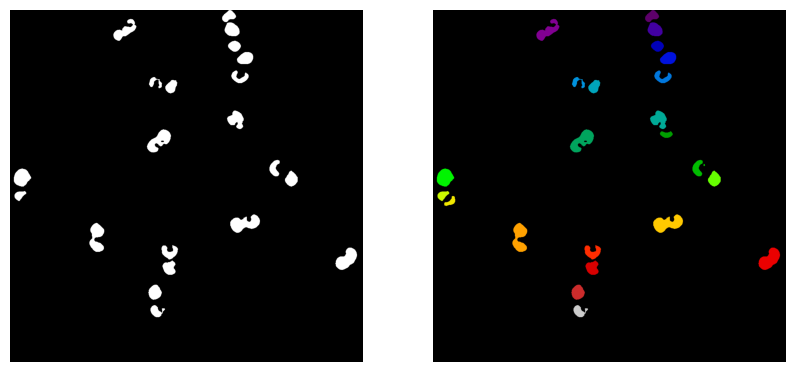

In [23]:
#hay varias celulas separables que figuran como una única componente conexa, hay que intentar separarlos
mascara_grandes = np.zeros_like(mascara_binaria)
n_cc, img_cc, values, centroids = cv2.connectedComponentsWithStats(mascara_filtrada, connectivity=8)

for i in range(1, n_cc): 
    if values[i, cv2.CC_STAT_AREA] > 2700:
        mascara_grandes[img_cc == i] = 255  # mantengo solo las más grandes (las dobles/triples)

kernel = np.ones((4, 4), np.uint8)  
dos_celulas_erosionada = cv2.erode(mascara_grandes, kernel, iterations=2)
n_cc, img_cc, values, centroids = cv2.connectedComponentsWithStats(mascara_filtrada, connectivity=8)


for j in range(1, n_cc):
    if values[j, cv2.CC_STAT_AREA] < 3000:
        dos_celulas_erosionada[img_cc == j] = 0 
img_blur = cv2.medianBlur(dos_celulas_erosionada, 15)
n_cc, img_cc, values, centroids = cv2.connectedComponentsWithStats(img_blur, connectivity=8)
for k in range(1, n_cc):
    if values[k, cv2.CC_STAT_AREA] < 500:
        img_blur[img_cc == k] = 0 

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_cc, cmap='nipy_spectral')
plt.axis("off")
print("CC=", n_cc)

plt.show()

(-0.5, 999.5, 999.5, -0.5)

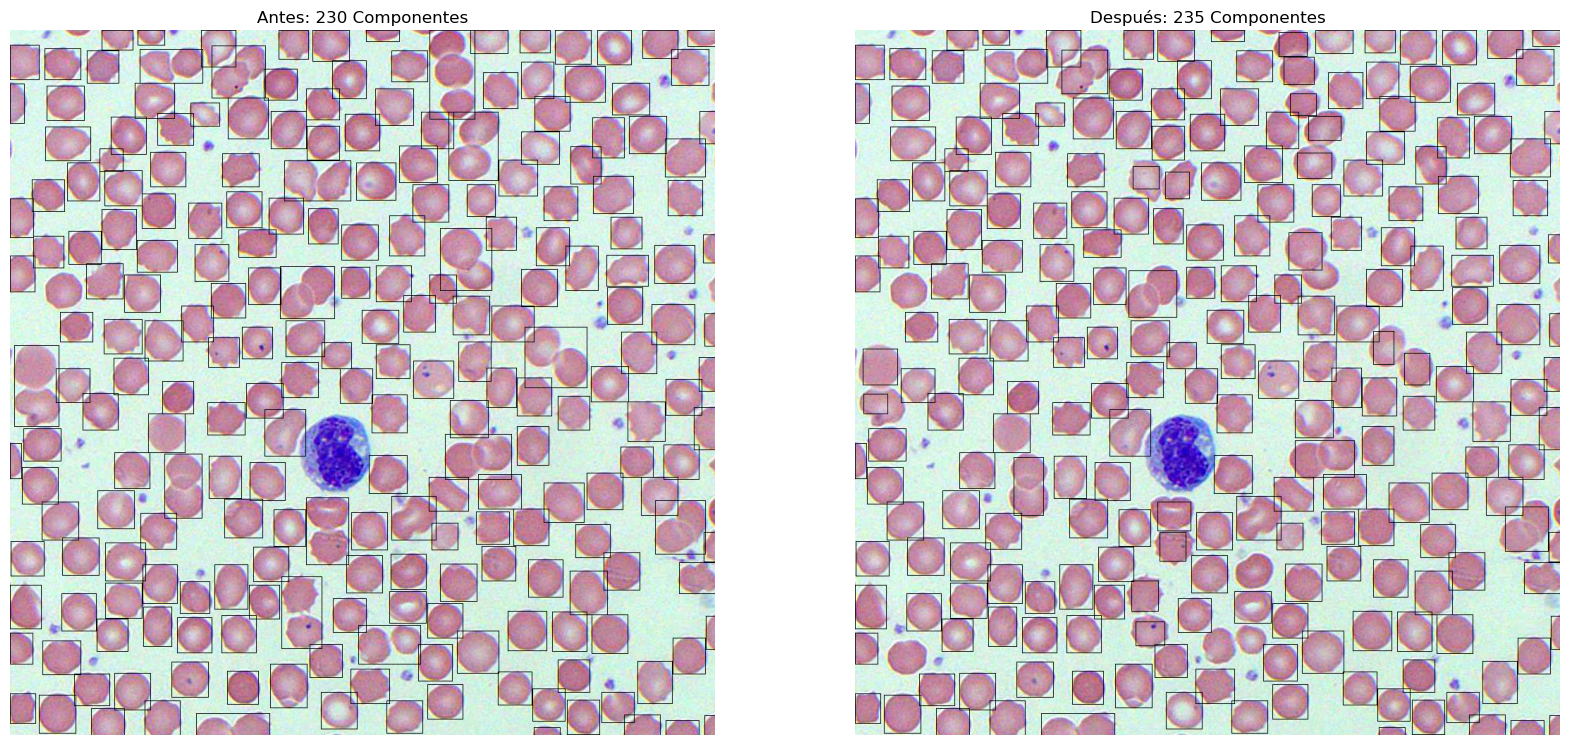

In [24]:
#elimino las componentes dobles y las reemplazo por sus versiones erosionadas y filtradas
mascara_corregida = mascara_filtrada.copy()

n_cc, img_cc, values, centroids = cv2.connectedComponentsWithStats(mascara_filtrada, connectivity=8)
for i in range(1, n_cc):
    componente_actual = (img_cc == i).astype(np.uint8) * 255
    if np.any(cv2.bitwise_and(componente_actual, mascara_grandes)):
        mascara_corregida[img_cc == i] = 0

mascara_binaria_actualizada = cv2.bitwise_or(mascara_corregida, img_blur)
imagen_con_cuadraditos_1 = img_celulas.copy()

n_cc, im_cc, values, centroids = cv2.connectedComponentsWithStats(mascara_binaria_actualizada, connectivity=8)
for j in range(1, n_cc): 
    if values[j, cv2.CC_STAT_AREA] < 450:
        mascara_binaria_actualizada[img_cc == j] = 0 

n_cc_2, im_cc, values, centroids = cv2.connectedComponentsWithStats(mascara_binaria_actualizada, connectivity=8)
for j in range(1, n_cc_2): 
    x, y, w, h, area = values[j]
    cv2.rectangle(imagen_con_cuadraditos_1, (x, y), (x + w, y + h), 2)

plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imagen_con_cuadraditos, cv2.COLOR_BGR2RGB))
plt.title(f"Antes: {n_cc_1} Componentes")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(imagen_con_cuadraditos_1, cv2.COLOR_BGR2RGB))
plt.title(f"Después: {n_cc_2} Componentes")
plt.axis("off")

#### Es una mejora ya que algunos grupos de células que figuraban como una sola componente, ya tienen para cada célula una propia.